In [1]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from sklearn.metrics import accuracy_score

In [2]:
image_transform = transforms.ToTensor()

In [3]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=image_transform)
valid_dataset = FashionMNIST(".", train=False, download=True, transform=image_transform)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:14<00:00, 1842789.01it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 566165.34it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3781720.31it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 16101623.41it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [5]:
def draw_losses(train_loss, valid_loss):
    plt.figure(figsize=(12, 8), num ="loss")
    plt.plot(train_loss, color="blue", label="train")
    plt.plot(valid_loss, color="orange", label="valid")

In [6]:
class SimpleNet(nn.Module):
    
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lr1 = nn.Linear(input_size, 2048)
        self.lr2 = nn.Linear(2048, 2048)
        self.lr3 = nn.Linear(2048, 2048)
        self.lr4 = nn.Linear(2048, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.lr1(x))
        x = F.relu(self.lr2(x))
        x = F.relu(self.lr3(x))
        x = self.lr4(x)
        return x

In [7]:
net = SimpleNet(28 * 28, len(train_dataset.classes))

In [8]:
net = net.to("cuda")

In [9]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [10]:
criteria = nn.CrossEntropyLoss()

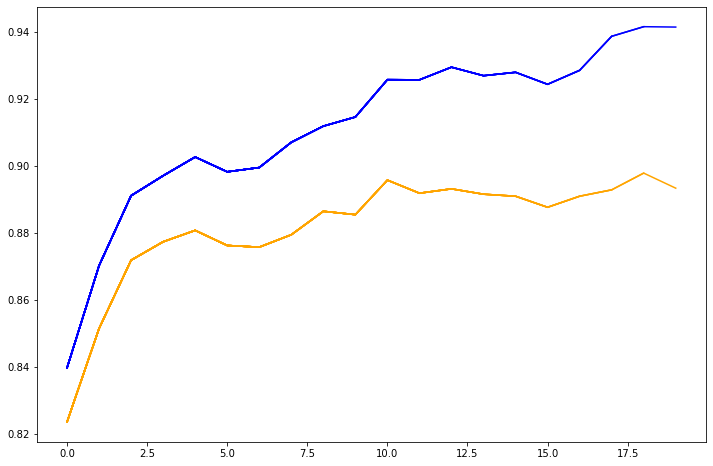

In [11]:
train_losses = []
valid_losses = []
for epoch in range(20):
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to("cuda")
        y = y.to("cuda")
        output = net(x.float())
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        y_pred = []
        y_true = []
        for x, y in valid_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        valid_losses.append(accuracy_score(y_true, y_pred))
        
        for x, y in train_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        train_losses.append(accuracy_score(y_true, y_pred))

        draw_losses(train_losses, valid_losses)

# Регуляризация 

Нейронные сети сильно поддвержены переобучению, особенно когда у них имеется большое число параметров. Чтобы уменьшить эффект данного процесса существуют различные методы регуляризации

## L2 L1 Regularization

Как и с линейной регрессией мы можем штрафовать веса во время их обновления в зависимости от их квадрата или модуля (значение или знак в производной)

In [12]:
net = SimpleNet(28 * 28, len(train_dataset.classes))

In [13]:
net = net.to("cuda")

In [14]:
# В практически всех оптимизаторах в pytorch есть l2 регуляризация, параметр weight_decay

optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

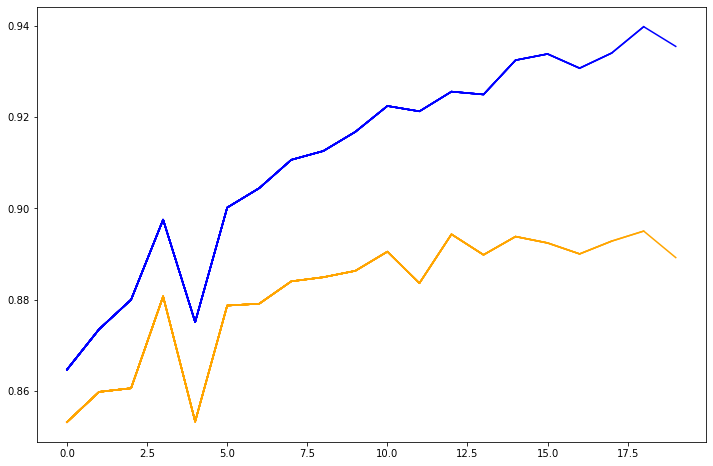

In [15]:
train_losses = []
valid_losses = []
for epoch in range(20):
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to("cuda")
        y = y.to("cuda")
        output = net(x.float())
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        y_pred = []
        y_true = []
        for x, y in valid_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        valid_losses.append(accuracy_score(y_true, y_pred))
        
        for x, y in train_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        train_losses.append(accuracy_score(y_true, y_pred))

        draw_losses(train_losses, valid_losses)

## Dropout

Но гораздо более действенным методом является dropout

Идея Dropout близка к l2 и l1 регуляризациям, мы хотим чтобы сеть обращала внимание на все признаки и не было слишком больших весов, однако подход отличается

<img src="img/dropout.jpeg">

Dropout во время forward pass делает некоторые из весов равными 0 - тем саммым исключая их из forward, во время backward они так же не учитываются

Исключаются веса случайно с вероятностью p

Однако после того как обучили сеть используются все веса и поскольку из суммарный вклад (xW), будет больше чем на этапе обучения выход линейного слоя дополнительно домножают на q = 1 - p (вероятность весов остаться)

### Inversed Dropout

Прямой dropout сейчас встречается достаточно редко и вместо него используется инвертированный, идея которого состоит в том чтобы не занижать веса во время предсказания, а увеличивать веса которые остались после Dropout

на этапе тренировке веса домножаются на $\large{\frac{1}{q} = \frac{1}{1 - p}}$

In [16]:
# в pytorch представлен inversed dropout

nn.Dropout?

Init signature: nn.Dropout(p: float = 0.5, inplace: bool = False) -> None
Docstring:     
During training, randomly zeroes some of the elements of the input
tensor with probability :attr:`p` using samples from a Bernoulli
distribution. Each channel will be zeroed out independently on every forward
call.

This has proven to be an effective technique for regularization and
preventing the co-adaptation of neurons as described in the paper
`Improving neural networks by preventing co-adaptation of feature
detectors`_ .

Furthermore, the outputs are scaled by a factor of :math:`\frac{1}{1-p}` during
training. This means that during evaluation the module simply computes an
identity function.

Args:
    p: probability of an element to be zeroed. Default: 0.5
    inplace: If set to ``True``, will do this operation in-place. Default: ``False``

Shape:
    - Input: :math:`(*)`. Input can be of any shape
    - Output: :math:`(*)`. Output is of the same shape as input

Examples::

    >>> m = nn.Dr

In [17]:
class SimpleNet(nn.Module):
    
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lr1 = nn.Linear(input_size, 2048)
        self.lr2 = nn.Linear(2048, 2048)
        self.lr3 = nn.Linear(2048, 2048)
        self.lr4 = nn.Linear(2048, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.dropout(F.relu(self.lr1(x)), p=0.1)
        x = F.dropout(F.relu(self.lr2(x)), p=0.1)
        x = F.dropout(F.relu(self.lr3(x)), p=0.1)
        x = F.dropout(self.lr4(x), p=0.1)
        return x

In [18]:
net = SimpleNet(28 * 28, len(train_dataset.classes))

In [19]:
net = net.to("cuda")

In [20]:
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

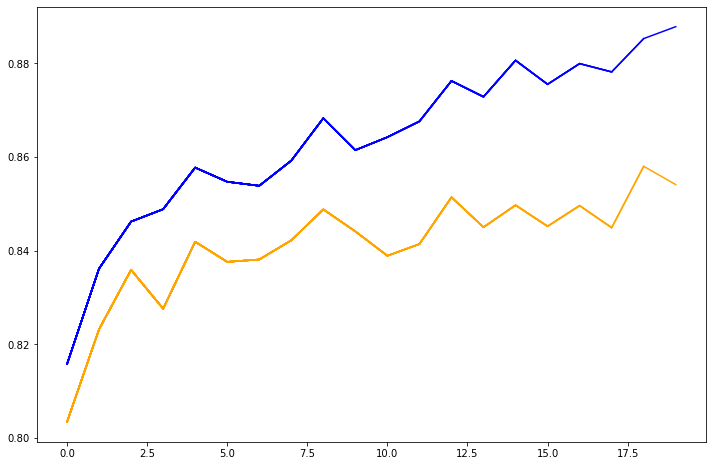

In [21]:
train_losses = []
valid_losses = []
for epoch in range(20):
    net.train() # переводим сеть в стадию тренировки
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to("cuda")
        y = y.to("cuda")
        output = net(x.float())
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()
    
    net.eval() # теперь когда у нас появился слой который по разному себя ведет на тренировке и инференсе, не забывать переводить сетку в стадию инференса
    with torch.no_grad():
        y_pred = []
        y_true = []
        
        for x, y in valid_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        valid_losses.append(accuracy_score(y_true, y_pred))
        
        for x, y in train_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        train_losses.append(accuracy_score(y_true, y_pred))

        draw_losses(train_losses, valid_losses)

## BatchNorm

Хоть batch norm и не является прямой регуляризацией однако он позволяет увеличить скорость обучения сети и ее качество

В чем же идея batch norm, у нас есть несколько линейных слоев, каждый из которых по сути отдельная линейная регрессия со своим входом

Мы знаем что линейная регрессия крайне чувствительна к масштабированию признаков, для того чтобы градиент учитывал все направления.

А не только направления с наибольшим признаком. Тогда давайте будем после каждого выхода из активации применять нормализацию признаков чтобы нормализовать масштаб

$$\large{x_{new} = \frac{x - \mu}{\sigma}}$$

Но учтем что распределение необязательно должно приходить к стандартному нормальному, давайте просто сделаем единное среднее для всех признаков и единую дисперсию и будем обучать эти параметры

$$\large{x_{new} = \gamma \frac{x - \mu}{\sigma} + \beta}$$

$\gamma$, $\beta$ - обучаемые параметры

$\mu$, $\sigma$ - высчитываются из статистик батчей

Сети с BatchNorm необходимо так же переводить в inference режим, чтобы не накапливать статистику батча (особенно если предсказывается отдельный семпл)

In [22]:
# батчнорм требует лишь размерность входящего вектора
nn.BatchNorm1d?

Init signature:
nn.BatchNorm1d(
    num_features: int,
    eps: float = 1e-05,
    momentum: float = 0.1,
    affine: bool = True,
    track_running_stats: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies Batch Normalization over a 2D or 3D input as described in the paper
`Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

.. math::

    y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

The mean and standard-deviation are calculated per-dimension over
the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
of size `C` (where `C` is the number of features or channels of the input). By default, the
elements of :math:`\gamma` are set to 1 and the elements of :math:`\beta` are set to 0.
At train time in the forward pass, the standard-deviation is calculated via the biased estimator,
equivalent to ``torch.var(input, u

In [23]:
class SimpleNet(nn.Module):
    
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lr1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.lr2 = nn.Linear(2048, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.lr3 = nn.Linear(2048, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        self.lr4 = nn.Linear(2048, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.dropout(self.bn1(F.relu(self.lr1(x))), p=0.1)
        x = F.dropout(self.bn2(F.relu(self.lr2(x))), p=0.1)
        x = F.dropout(self.bn3(F.relu(self.lr3(x))), p=0.1)
        x = F.dropout(self.lr4(x), p=0.1)
        return x

In [24]:
net = net.to("cuda")

In [25]:
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

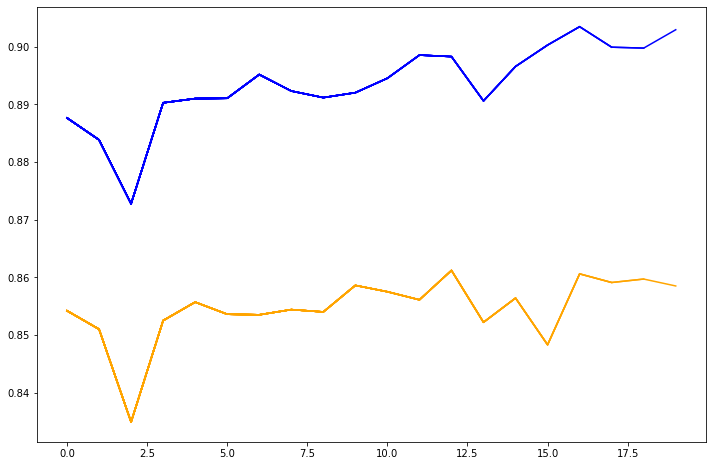

In [26]:
train_losses = []
valid_losses = []
for epoch in range(20):
    net.train() # переводим сеть в стадию тренировки
    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to("cuda")
        y = y.to("cuda")
        output = net(x.float())
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()
    
    net.eval() # теперь когда у нас появился слой который по разному себя ведет на тренировке и инференсе, не забывать переводить сетку в стадию инференса
    with torch.no_grad():
        y_pred = []
        y_true = []
        
        for x, y in valid_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        valid_losses.append(accuracy_score(y_true, y_pred))
        
        for x, y in train_loader:
            x = x.to("cuda")
            y_true.extend(y)
            y = y.to("cuda")
            output = net(x.float())
            y_pred.extend(output.argmax(1).cpu())
        train_losses.append(accuracy_score(y_true, y_pred))

        draw_losses(train_losses, valid_losses)